# Importing necessary things

In [3]:
import pandas as pd
import numpy as np
import sklearn

import sklearn.metrics as metrics
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import svm
from sklearn.svm import SVC

from tqdm import tqdm

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, RegexpTokenizer, TweetTokenizer

import matplotlib.pyplot as plt
import seaborn as sns

import re
from datetime import datetime

import pickle

==================================================================================================================

# Preparing text for modeling

In [4]:
# Retreiving our tokens.

from pathlib import Path

root = Path('.')

#global
my_path1 = root / "tokens" / "processedreviewrating1.pbz2"
my_path2 = root / "tokens" / "processedreviewrating2.pbz2"
my_path3 = root / "tokens" / "processedreviewrating3.pbz2"
my_path4 = root / "tokens" / "processedreviewrating4.pbz2"
my_path5 = root / "tokens" / "processedreviewrating5.pbz2"

#sea
my_path6 = root / "tokens" / "processedreviewrating6.pbz2"
my_path7 = root / "tokens" / "processedreviewrating7.pbz2"
my_path8 = root / "tokens" / "processedreviewrating8.pbz2"
my_path9 = root / "tokens" / "processedreviewrating9.pbz2"
my_path10 = root / "tokens" / "processedreviewrating10.pbz2"

import bz2

def compressed_pickle(path, data):
    with bz2.BZ2File(path, 'w') as f:
        pickle.dump(data, f)

def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = pickle.load(data)
    return data

In [5]:
rating1global = decompress_pickle(my_path1)
rating2global = decompress_pickle(my_path2)
rating3global = decompress_pickle(my_path3)
rating4global = decompress_pickle(my_path4)
rating5global = decompress_pickle(my_path5)

rating1sea = decompress_pickle(my_path6)
rating2sea = decompress_pickle(my_path7)
rating3sea = decompress_pickle(my_path8)
rating4sea = decompress_pickle(my_path9)
rating5sea = decompress_pickle(my_path10)

In [6]:
# Putting everything together.

dfglobal = pd.concat([rating1global, rating2global, rating3global, rating4global, rating5global])
dfsea = pd.concat([rating1sea, rating2sea, rating3sea, rating4sea, rating5sea])

In [7]:
# Remove common words
stopwords_list = stopwords.words('english') + list(string.punctuation)
# Remove more punctuation
stopwords_list += ["''", '""', '...', '``']

In [8]:
def process_reviews(reviews):
    tokens = nltk.word_tokenize(reviews)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed  

lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

In [9]:
dfglobal['wordlist'] = dfglobal['content'].apply(lambda x: process_reviews(x))
dfglobal['wordlistlem'] = dfglobal['wordlist'].apply(lemmatize_text)
dfglobal['strings'] = [' '.join(i) for i in dfglobal['wordlistlem']]

dfsea['wordlist'] = dfsea['content'].apply(lambda x: process_reviews(x))
dfsea['wordlistlem'] = dfsea['wordlist'].apply(lemmatize_text)
dfsea['strings'] = [' '.join(i) for i in dfsea['wordlistlem']]

In [10]:
dfglobal.head()

content  score  thumbsUpCount  \
0                                       Not permitted      1              0   
2   P2W till the end, prices are way too high... A...      1              0   
5                                            Cashgrab      1              0   
12  This new patch update made the game so laggy, ...      1              2   
16  Awful. With the recent update, I am unable to ...      1              2   

   reviewCreatedVersion         at replyContent               appId month  \
0                  None 2020-12-20         None  com.gravity.romNAg    12   
2                  None 2020-12-17         None  com.gravity.romNAg    12   
5                  None 2020-12-11         None  com.gravity.romNAg    12   
12                1.2.6 2020-12-08         None  com.gravity.romNAg    12   
16                1.2.6 2020-12-01         None  com.gravity.romNAg    12   

    numwords  numuniquewords  numchars  numpuncts  numcapts  numtitles  \
0          2               2        13          0         0          1   
2         21              20       107          7         1          3   
5          1               1         8          0         0          1   
12        40              38       210          4         3          5   
16        46              37       223          5         4          8   

    meanwordlength                                           wordlist  \
0         6.000000                                        [permitted]   
2         4.142857  [p2w, till, end, prices, way, high, beginning,...   
5         8.000000                                         [cashgrab]   
12        4.275000  [new, patch, update, made, game, laggy, takes,...   
16        3.869565  [awful, recent, update, unable, switch, main, ...   

                                          wordlistlem  \
0                                         [permitted]   
2   [p2w, till, end, price, way, high, beginning, ...   
5                                          [cashgrab]   
12  [new, patch, update, made, game, laggy, take, ...   
16  [awful, recent, update, unable, switch, main, ...   

                                              strings  
0                                           permitted  
2   p2w till end price way high beginning amazing ...  
5                                            cashgrab  
12  new patch update made game laggy take 30 secon...  
16  awful recent update unable switch main account...

In [11]:
dfsea.head()

content  score  thumbsUpCount  \
1   new update made several freezing screen. can't...      1              0   
3                                           Lag delay      1              0   
5   Why is the latest update so laggy .. You updat...      1              0   
10                              IMO MAMA STAY AWESOME      1              0   
12  Devs dont even hide the fact that you need to ...      1              0   

   reviewCreatedVersion         at replyContent             appId month  \
1                1.0.35 2020-12-20         None  com.gravity.romg    12   
3                1.0.35 2020-12-20         None  com.gravity.romg    12   
5                1.0.35 2020-12-20         None  com.gravity.romg    12   
10                 None 2020-12-19         None  com.gravity.romg    12   
12                 None 2020-12-19         None  com.gravity.romg    12   

    numwords  numuniquewords  numchars  numpuncts  numcapts  numtitles  \
1         34              31       190          3         0          0   
3          2               2         9          0         0          1   
5         19              18       102          4         0          3   
10         4               4        21          0         4          0   
12        16              15        74          1         0          1   

    meanwordlength                                           wordlist  \
1         4.617647  [new, update, made, several, freezing, screen,...   
3         4.000000                                       [lag, delay]   
5         4.421053  [latest, update, laggy, .., updated, develop, ...   
10        4.500000                         [imo, mama, stay, awesome]   
12        3.687500  [devs, dont, even, hide, fact, need, spend, lo...   

                                          wordlistlem  \
1   [new, update, made, several, freezing, screen,...   
3                                        [lag, delay]   
5   [latest, update, laggy, .., updated, develop, ...   
10                         [imo, mama, stay, awesome]   
12  [devs, dont, even, hide, fact, need, spend, lo...   

                                              strings  
1   new update made several freezing screen ca n't...  
3                                           lag delay  
5   latest update laggy .. updated develop lagging...  
10                              imo mama stay awesome  
12  devs dont even hide fact need spend lot get st...

==================================================================================================================

# TF-IDF

In [12]:
xglobal = dfglobal['strings']
yglobal = dfglobal['score']

X_trainglobal, X_testglobal, y_trainglobal, y_testglobal = train_test_split(xglobal, yglobal, random_state = 44)

In [13]:
xsea = dfsea['strings']
ysea = dfsea['score']

X_trainsea, X_testsea, y_trainsea, y_testsea = train_test_split(xsea, ysea, random_state = 44)

In [14]:
vec = TfidfVectorizer()

tfidf_X_trainglobal = vec.fit_transform(X_trainglobal)
tfidf_X_testglobal = vec.transform(X_testglobal)

tfidf_X_trainsea = vec.fit_transform(X_trainsea)
tfidf_X_testsea = vec.transform(X_testsea)

## Dummy Classifier Baseline Model

### Global

In [15]:
from sklearn.dummy import DummyClassifier

dclfgl = DummyClassifier()
dclfgl.fit(tfidf_X_trainglobal, y_trainglobal)
y_preds_dummyglobal = dclfgl.predict(tfidf_X_testglobal)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [16]:
#Evaluation Metrics for Dummy Classifier for ROM Global

print("Test Accuracy Score:", metrics.accuracy_score(y_testglobal, y_preds_dummyglobal))
print("Test Precision Score:", metrics.precision_score(y_testglobal, y_preds_dummyglobal, average = "weighted"))
print("Test Recall Score:", metrics.recall_score(y_testglobal, y_preds_dummyglobal, average = "weighted"))
print("Test F1 Score:", metrics.f1_score(y_testglobal, y_preds_dummyglobal, average = "weighted"))

Test Accuracy Score: 0.3318912237330037
Test Precision Score: 0.3248822250426742
Test Recall Score: 0.3318912237330037
Test F1 Score: 0.3278794627326058


### SEA

In [17]:
dclfsea = DummyClassifier()
dclfsea.fit(tfidf_X_trainsea, y_trainsea)
y_preds_dummysea = dclfsea.predict(tfidf_X_testsea)

In [18]:
#Evaluation Metrics for Dummy Classifier for ROM SEA

print("Test Accuracy Score:", metrics.accuracy_score(y_testsea, y_preds_dummysea))
print("Test Precision Score:", metrics.precision_score(y_testsea, y_preds_dummysea, average = "weighted"))
print("Test Recall Score:", metrics.recall_score(y_testsea, y_preds_dummysea, average = "weighted"))
print("Test F1 Score:", metrics.f1_score(y_testsea, y_preds_dummysea, average = "weighted"))

Test Accuracy Score: 0.36672024832326366
Test Precision Score: 0.3701137380953354
Test Recall Score: 0.36672024832326366
Test F1 Score: 0.36839509436993645


==================================================================================================================

## Naive Bayes

### Global

In [19]:
NBgl = MultinomialNB(fit_prior = False)

NBgl.fit(tfidf_X_trainglobal,y_trainglobal)

y_pred_nb_testglobal = NBgl.predict(tfidf_X_testglobal)

print("Test Accuracy Score:", metrics.accuracy_score(y_testglobal, y_pred_nb_testglobal))
print("Test Precision Score:", metrics.precision_score(y_testglobal, y_pred_nb_testglobal, average = "weighted"))
print("Test Recall Score:", metrics.recall_score(y_testglobal, y_pred_nb_testglobal, average = "weighted"))
print("Test F1 Score:", metrics.f1_score(y_testglobal, y_pred_nb_testglobal, average = "weighted"))

Test Accuracy Score: 0.6687268232385661
Test Precision Score: 0.5756540728294953
Test Recall Score: 0.6687268232385661
Test F1 Score: 0.5889646838985917


Text(91.68, 0.5, 'Predicted Rating')

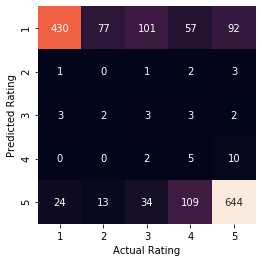

In [20]:
matrix = confusion_matrix(y_testglobal, y_pred_nb_testglobal)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['1','2','3','4','5'], yticklabels=['1','2','3','4','5'])

plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

### SEA

In [21]:
NBsea = MultinomialNB(fit_prior = False)

NBsea.fit(tfidf_X_trainsea,y_trainsea)

y_pred_nb_testsea = NBsea.predict(tfidf_X_testsea)

print("Test Accuracy Score:", metrics.accuracy_score(y_testsea, y_pred_nb_testsea))
print("Test Precision Score:", metrics.precision_score(y_testsea, y_pred_nb_testsea, average = "weighted"))
print("Test Recall Score:", metrics.recall_score(y_testsea, y_pred_nb_testsea, average = "weighted"))
print("Test F1 Score:", metrics.f1_score(y_testsea, y_pred_nb_testsea, average = "weighted"))

Test Accuracy Score: 0.7262346876558949
Test Precision Score: 0.677890453129581
Test Recall Score: 0.7262346876558949
Test F1 Score: 0.6905947072900763


Text(91.68, 0.5, 'Predicted Rating')

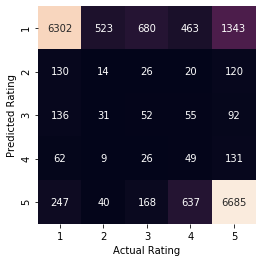

In [22]:
matrix = confusion_matrix(y_testsea, y_pred_nb_testsea)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['1','2','3','4','5'], yticklabels=['1','2','3','4','5'])

plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

==================================================================================================================

## Decision Tree

### Global

In [23]:
dtcgl = DecisionTreeClassifier()

dtcgl.fit(tfidf_X_trainglobal, y_trainglobal)

y_pred_dtc_testglobal = dtcgl.predict(tfidf_X_testglobal)

print("Test Accuracy Score:", metrics.accuracy_score(y_testglobal, y_pred_dtc_testglobal))
print("Test Precision Score:", metrics.precision_score(y_testglobal, y_pred_dtc_testglobal, average = "weighted"))
print("Test Recall Score:", metrics.recall_score(y_testglobal, y_pred_dtc_testglobal, average = "weighted"))
print("Test F1 Score:", metrics.f1_score(y_testglobal, y_pred_dtc_testglobal, average = "weighted"))

Test Accuracy Score: 0.5828182941903585
Test Precision Score: 0.5517076557322531
Test Recall Score: 0.5828182941903585
Test F1 Score: 0.5650720155946124


Text(91.68, 0.5, 'Predicted Rating')

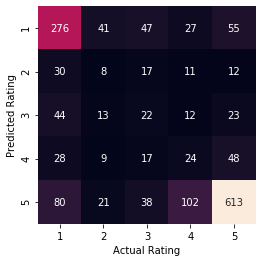

In [24]:
matrix = confusion_matrix(y_testglobal, y_pred_dtc_testglobal)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['1','2','3','4','5'], yticklabels=['1','2','3','4','5'])

plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

### SEA

In [25]:
dtcsea = DecisionTreeClassifier()

dtcsea.fit(tfidf_X_trainsea, y_trainsea)

y_pred_dtc_testsea = dtcsea.predict(tfidf_X_testsea)

print("Test Accuracy Score:", metrics.accuracy_score(y_testsea, y_pred_dtc_testsea))
print("Test Precision Score:", metrics.precision_score(y_testsea, y_pred_dtc_testsea, average = "weighted"))
print("Test Recall Score:", metrics.recall_score(y_testsea, y_pred_dtc_testsea, average = "weighted"))
print("Test F1 Score:", metrics.f1_score(y_testsea, y_pred_dtc_testsea, average = "weighted"))

Test Accuracy Score: 0.6986863255917077
Test Precision Score: 0.6647125048305412
Test Recall Score: 0.6986863255917077
Test F1 Score: 0.6803483128842415


Text(91.68, 0.5, 'Predicted Rating')

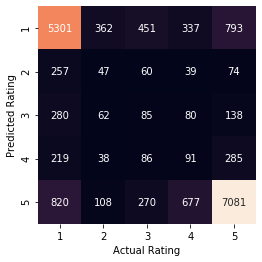

In [26]:
matrix = confusion_matrix(y_testsea, y_pred_dtc_testsea)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['1','2','3','4','5'], yticklabels=['1','2','3','4','5'])

plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

==================================================================================================================

## Random Forest

### Global

In [27]:
rfcgl = RandomForestClassifier()

rfcgl.fit(tfidf_X_trainglobal, y_trainglobal)

y_pred_rfc_testglobal = rfcgl.predict(tfidf_X_testglobal)

print("Test Accuracy Score:", metrics.accuracy_score(y_testglobal, y_pred_rfc_testglobal))
print("Test Precision Score:", metrics.precision_score(y_testglobal, y_pred_rfc_testglobal, average = "weighted"))
print("Test Recall Score:", metrics.recall_score(y_testglobal, y_pred_rfc_testglobal, average = "weighted"))
print("Test F1 Score:", metrics.f1_score(y_testglobal, y_pred_rfc_testglobal, average = "weighted"))

Test Accuracy Score: 0.6674907292954264
Test Precision Score: 0.5651900373859852
Test Recall Score: 0.6674907292954264
Test F1 Score: 0.579991930811728


Text(91.68, 0.5, 'Predicted Rating')

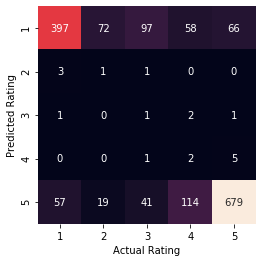

In [28]:
matrix = confusion_matrix(y_testglobal, y_pred_rfc_testglobal)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['1','2','3','4','5'], yticklabels=['1','2','3','4','5'])

plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

### SEA

In [29]:
rfcsea = RandomForestClassifier()

rfcsea.fit(tfidf_X_trainsea, y_trainsea)

y_pred_rfc_testsea = rfcsea.predict(tfidf_X_testsea)

print("Test Accuracy Score:", metrics.accuracy_score(y_testsea, y_pred_rfc_testsea))
print("Test Precision Score:", metrics.precision_score(y_testsea, y_pred_rfc_testsea, average = "weighted"))
print("Test Recall Score:", metrics.recall_score(y_testsea, y_pred_rfc_testsea, average = "weighted"))
print("Test F1 Score:", metrics.f1_score(y_testsea, y_pred_rfc_testsea, average = "weighted"))

Test Accuracy Score: 0.7553904994179923
Test Precision Score: 0.6689902317348971
Test Recall Score: 0.7553904994179923
Test F1 Score: 0.6981747064250369


Text(91.68, 0.5, 'Predicted Rating')

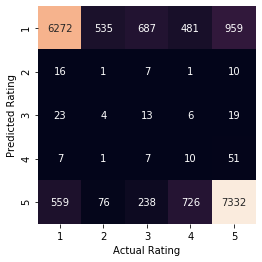

In [30]:
matrix = confusion_matrix(y_testsea, y_pred_rfc_testsea)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['1','2','3','4','5'], yticklabels=['1','2','3','4','5'])

plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

==================================================================================================================

## Support Vector Machine

### Global

In [31]:
SVMgl = svm.SVC()
SVMgl.fit(tfidf_X_trainglobal, y_trainglobal)

y_pred_SVM_testglobal = SVMgl.predict(tfidf_X_testglobal)

print("Test Accuracy Score:", metrics.accuracy_score(y_testglobal, y_pred_SVM_testglobal))
print("Test Precision Score:", metrics.precision_score(y_testglobal, y_pred_SVM_testglobal, average = "weighted"))
print("Test Recall Score:", metrics.recall_score(y_testglobal, y_pred_SVM_testglobal, average = "weighted"))
print("Test F1 Score:", metrics.f1_score(y_testglobal, y_pred_SVM_testglobal, average = "weighted"))

Test Accuracy Score: 0.6841779975278122
Test Precision Score: 0.5872740271369469
Test Recall Score: 0.6841779975278122
Test F1 Score: 0.5949577097822947


Text(91.68, 0.5, 'Predicted Rating')

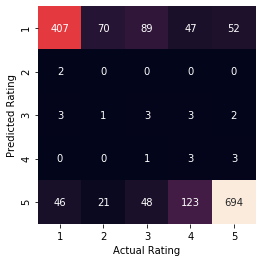

In [32]:
matrix = confusion_matrix(y_testglobal, y_pred_SVM_testglobal)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['1','2','3','4','5'], yticklabels=['1','2','3','4','5'])

plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

### SEA

In [33]:
starttime = datetime.now()

#######

SVMsea = svm.SVC()
SVMsea.fit(tfidf_X_trainsea, y_trainsea)

y_pred_SVM_testsea = SVMsea.predict(tfidf_X_testsea)

print("Test Accuracy Score:", metrics.accuracy_score(y_testsea, y_pred_SVM_testsea))
print("Test Precision Score:", metrics.precision_score(y_testsea, y_pred_SVM_testsea, average = "weighted"))
print("Test Recall Score:", metrics.recall_score(y_testsea, y_pred_SVM_testsea, average = "weighted"))
print("Test F1 Score:", metrics.f1_score(y_testsea, y_pred_SVM_testsea, average = "weighted"))

#######

print('------------------------')
print(datetime.now() - starttime)

Test Accuracy Score: 0.7723518651959426
Test Precision Score: 0.6895906690359215
Test Recall Score: 0.7723518651959426
Test F1 Score: 0.7100195104243602


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(91.68, 0.5, 'Predicted Rating')

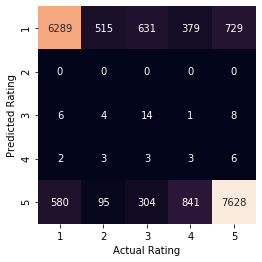

In [34]:
matrix = confusion_matrix(y_testsea, y_pred_SVM_testsea)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['1','2','3','4','5'], yticklabels=['1','2','3','4','5'])

plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

==================================================================================================================

## Gridsearch (Decision Tree)

In [35]:
dtc_param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [None, 2, 3, 4, 5, 6],
    'max_features': ['auto', 'log2', None],
    'min_samples_split' : [2, 3, 4, 5, 10, 15],
    'min_samples_leaf' : [1, 2, 3, 4, 5, 10]
}


### Global

In [36]:
starttime = datetime.now()

#######

dt_gridgl = GridSearchCV(dtcgl, dtc_param_grid, cv=5, return_train_score=True)

dt_gridgl.fit(tfidf_X_trainglobal, y_trainglobal)

#######

print(datetime.now() - starttime)

0:03:00.606323


In [37]:
dt_grid_trainscoregl = np.mean(dt_gridgl.cv_results_['mean_train_score'])

dt_grid_testscoregl = dt_gridgl.score(tfidf_X_trainglobal, y_trainglobal)

print(f"Mean Training Score: {dt_grid_trainscoregl : .2%}")
print(f"Mean Test Score: {dt_grid_testscoregl : .2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_gridgl.best_params_

Mean Training Score:  54.14%
Mean Test Score:  66.65%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 5}

In [38]:
dtcgl = DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='auto', min_samples_leaf=3, min_samples_split=5, random_state=22)

dtcgl.fit(tfidf_X_trainglobal, y_trainglobal)

y_pred_dtc_testglobal = dtcgl.predict(tfidf_X_testglobal)

print("Test Accuracy Score:", metrics.accuracy_score(y_testglobal, y_pred_dtc_testglobal))
print("Test Precision Score:", metrics.precision_score(y_testglobal, y_pred_dtc_testglobal, average = "weighted"))
print("Test Recall Score:", metrics.recall_score(y_testglobal, y_pred_dtc_testglobal, average = "weighted"))
print("Test F1 Score:", metrics.f1_score(y_testglobal, y_pred_dtc_testglobal, average = "weighted"))

Test Accuracy Score: 0.5914709517923362
Test Precision Score: 0.4941763960002753
Test Recall Score: 0.5914709517923362
Test F1 Score: 0.5286617948305732


Compare to:
- Test Accuracy Score: 0.5828182941903585 (INCREASE)
- Test Precision Score: 0.5517076557322531 (INCREASE)
- Test Recall Score: 0.5828182941903585 (INCREASE)
- Test F1 Score: 0.5650720155946124 (INCREASE)

Text(91.68, 0.5, 'Predicted Rating')

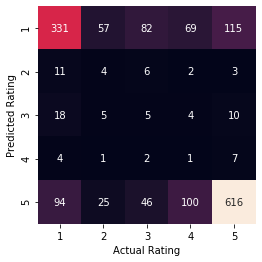

In [39]:
matrix = confusion_matrix(y_testglobal, y_pred_dtc_testglobal)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['1','2','3','4','5'], yticklabels=['1','2','3','4','5'])

plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

### SEA

In [40]:
starttime = datetime.now()

#######

dt_gridsea = GridSearchCV(dtcsea, dtc_param_grid, cv=5, return_train_score=True)

dt_gridsea.fit(tfidf_X_trainsea, y_trainsea)

#######

print(datetime.now() - starttime)

1:00:42.736163


In [41]:
dt_grid_trainscoresea = np.mean(dt_gridsea.cv_results_['mean_train_score'])

dt_grid_testscoresea = dt_gridsea.score(tfidf_X_trainsea, y_trainsea)

print(f"Mean Training Score: {dt_grid_trainscoresea : .2%}")
print(f"Mean Test Score: {dt_grid_testscoresea : .2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_gridsea.best_params_

Mean Training Score:  54.50%
Mean Test Score:  74.45%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 5}

In [42]:
dtcsea = DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='auto', min_samples_leaf=2, min_samples_split=2, random_state=22)

dtcsea.fit(tfidf_X_trainsea, y_trainsea)

y_pred_dtc_testsea = dtcsea.predict(tfidf_X_testsea)

print("Test Accuracy Score:", metrics.accuracy_score(y_testsea, y_pred_dtc_testsea))
print("Test Precision Score:", metrics.precision_score(y_testsea, y_pred_dtc_testsea, average = "weighted"))
print("Test Recall Score:", metrics.recall_score(y_testsea, y_pred_dtc_testsea, average = "weighted"))
print("Test F1 Score:", metrics.f1_score(y_testsea, y_pred_dtc_testsea, average = "weighted"))

Test Accuracy Score: 0.7209134748628124
Test Precision Score: 0.6480584233819887
Test Recall Score: 0.7209134748628124
Test F1 Score: 0.6733166501322316


- Test Accuracy Score: 0.6986863255917077 (INCREASE)
- Test Precision Score: 0.6647125048305412 (DECREASE)
- Test Recall Score: 0.6986863255917077 (INCREASE)
- Test F1 Score: 0.6803483128842415 (DECREASE)

Text(91.68, 0.5, 'Predicted Rating')

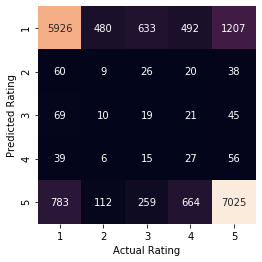

In [43]:
matrix = confusion_matrix(y_testsea, y_pred_dtc_testsea)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['1','2','3','4','5'], yticklabels=['1','2','3','4','5'])

plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

==================================================================================================================

## Gridsearch (Random Forest)

In [44]:
rf_param_grid = {
    'n_estimators' : [50, 100],
    'criterion' : ['gini'],
    'max_depth' : [None, 2, 4],
    'max_features': ['auto', 'log2', None],
    'min_samples_split' : [5, 10],
    'min_samples_leaf' : [1, 3]
}

### Global

In [45]:
starttime = datetime.now()

#######

rf_gridgl = GridSearchCV(rfcgl, rf_param_grid, cv=5)

rf_gridgl.fit(tfidf_X_trainglobal, y_trainglobal)

#######

print(datetime.now() - starttime)

0:12:31.870818


In [46]:
print(f"Training Accuracy: {rf_gridgl.best_score_ : .2%}")
print("Best Parameter Combination Found During Grid Search:")
rf_gridgl.best_params_

Training Accuracy:  66.72%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

In [47]:
rfcgl = RandomForestClassifier(n_estimators = 100, criterion='gini', max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=10, random_state = 11, n_jobs=-1)

rfcgl.fit(tfidf_X_trainglobal, y_trainglobal)

y_pred_rfc_testglobal = rfcgl.predict(tfidf_X_testglobal)

print("Test Accuracy Score:", metrics.accuracy_score(y_testglobal, y_pred_rfc_testglobal))
print("Test Precision Score:", metrics.precision_score(y_testglobal, y_pred_rfc_testglobal, average = "weighted"))
print("Test Recall Score:", metrics.recall_score(y_testglobal, y_pred_rfc_testglobal, average = "weighted"))
print("Test F1 Score:", metrics.f1_score(y_testglobal, y_pred_rfc_testglobal, average = "weighted"))

Test Accuracy Score: 0.6749072929542645
Test Precision Score: 0.5535034764322491
Test Recall Score: 0.6749072929542645
Test F1 Score: 0.5838392159702722


Compare to:

- Test Accuracy Score: 0.6674907292954264 (INCREASE)
- Test Precision Score: 0.5651900373859852 (DECREASE)
- Test Recall Score: 0.6674907292954264 (INCREASE)
- Test F1 Score: 0.579991930811728 (INCREASE)

Text(91.68, 0.5, 'Predicted Rating')

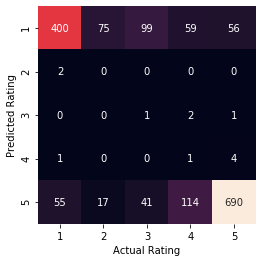

In [48]:
matrix = confusion_matrix(y_testglobal, y_pred_rfc_testglobal)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['1','2','3','4','5'], yticklabels=['1','2','3','4','5'])

plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

### SEA

In [49]:
starttime = datetime.now()

#######

#rf_gridsea = GridSearchCV(rfcsea, rf_param_grid, cv=5)

#rf_gridsea.fit(tfidf_X_trainsea, y_trainsea)

#######

print(datetime.now() - starttime)

# Takes too long to run

0:00:00.000039


In [50]:
#print(f"Training Accuracy: {rf_gridsea.best_score_ : .2%}")
#print("Best Parameter Combination Found During Grid Search:")
#rf_gridsea.best_params_

In [51]:
rfcsea = RandomForestClassifier(n_estimators = 100, criterion='gini', max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=10, random_state = 11, n_jobs=-1)

rfcsea.fit(tfidf_X_trainsea, y_trainsea)

y_pred_rfc_testsea = rfcsea.predict(tfidf_X_testsea)

print("Test Accuracy Score:", metrics.accuracy_score(y_testsea, y_pred_rfc_testsea))
print("Test Precision Score:", metrics.precision_score(y_testsea, y_pred_rfc_testsea, average = "weighted"))
print("Test Recall Score:", metrics.recall_score(y_testsea, y_pred_rfc_testsea, average = "weighted"))
print("Test F1 Score:", metrics.f1_score(y_testsea, y_pred_rfc_testsea, average = "weighted"))

Test Accuracy Score: 0.7599357020120836
Test Precision Score: 0.6736791608861975
Test Recall Score: 0.7599357020120836
Test F1 Score: 0.7004761029755466


Compared to:

- Test Accuracy Score: 0.7553904994179923 (INCREASE)
- Test Precision Score: 0.6689902317348971 (INCREASE)
- Test Recall Score: 0.7553904994179923 (INCREASE)
- Test F1 Score: 0.6981747064250369 (INCREASE)

Text(91.68, 0.5, 'Predicted Rating')

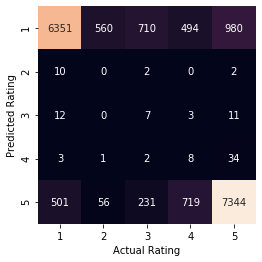

In [52]:
matrix = confusion_matrix(y_testsea, y_pred_rfc_testsea)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['1','2','3','4','5'], yticklabels=['1','2','3','4','5'])

plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

==================================================================================================================

## Gridsearch (Support Vector Machine)

In [53]:
svm_param_grid = {
    'C' : [0.1, 1, 10],
    'gamma' : [1, 0.1, 0.01],
    'kernel' : ['linear', 'nonlinear', 'sigmoid', 'polynomial']
}

### Global

In [54]:
starttime = datetime.now()

#######

svm_gridgl = GridSearchCV(SVMgl, svm_param_grid, refit=True, verbose=3)

svm_gridgl.fit(tfidf_X_trainglobal, y_trainglobal)

#######

print(datetime.now() - starttime)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.649, total=   2.2s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.662, total=   2.2s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.656, total=   2.2s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.651, total=   2.2s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.651, total=   2.2s
[CV] C=0.1, gamma=1, kernel=nonlinear ................................
[CV] ...... C=0.1, gamma=1, kernel=nonlinear, score=nan, total=   0.0s
[CV] C=0.1, gamma=1, kernel=nonlinear ................................
[CV] ...... C=0.1, gamma=1, kernel=nonlinear, score=nan, total=   0.0s
[CV] C=0.1, gamma=1, kernel=nonlinear ................................
[CV] ...... C=0.1, gamma=1, kernel=nonlinear, score=nan, total=   0.0s
[CV] C=0.1, gamma=1, kernel=nonlinear ................................
[CV] ...... C=0.1, gamma=1, kernel=nonlinear, score=nan, total=   0.0s
[CV] C=0.1, gamma=1, kernel=nonlinear ................................
[CV] .

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py", line 285, in _sparse_fit
    kernel_type = self._sparse_kernels.index(kernel)
ValueError: 'nonlinear' is not in list

  FitFailedWarning)


[CV] ...... C=0.1, gamma=1, kernel=sigmoid, score=0.645, total=   2.2s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ...... C=0.1, gamma=1, kernel=sigmoid, score=0.657, total=   2.2s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ...... C=0.1, gamma=1, kernel=sigmoid, score=0.657, total=   2.2s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ...... C=0.1, gamma=1, kernel=sigmoid, score=0.647, total=   2.2s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ...... C=0.1, gamma=1, kernel=sigmoid, score=0.645, total=   2.2s
[CV] C=0.1, gamma=1, kernel=polynomial ...............................
[CV] ..... C=0.1, gamma=1, kernel=polynomial, score=nan, total=   0.0s
[CV] C=0.1, gamma=1, kernel=polynomial ...............................
[CV] ..... C=0.1, gamma=1, kernel=polynomial, score=nan, total=   0.0s
[CV] C=0.1, gamma=1, kernel=polynomial ...............................
[CV] .

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py", line 285, in _sparse_fit
    kernel_type = self._sparse_kernels.index(kernel)
ValueError: 'polynomial' is not in list

  FitFailedWarning)


[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.649, total=   2.2s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.662, total=   2.2s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.656, total=   2.2s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.651, total=   2.2s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.651, total=   2.2s
[CV] C=0.1, gamma=0.1, kernel=nonlinear ..............................
[CV] .... C=0.1, gamma=0.1, kernel=nonlinear, score=nan, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=nonlinear ..............................
[CV] .... C=0.1, gamma=0.1, kernel=nonlinear, score=nan, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=nonlinear ..............................
[CV] .

[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.675, total=   2.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.673, total=   2.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.699, total=   2.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.676, total=   2.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.679, total=   2.0s
[CV] C=1, gamma=0.1, kernel=nonlinear ................................
[CV] ...... C=1, gamma=0.1, kernel=nonlinear, score=nan, total=   0.0s
[CV] C=1, gamma=0.1, kernel=nonlinear ................................
[CV] ...... C=1, gamma=0.1, kernel=nonlinear, score=nan, total=   0.0s
[CV] C=1, gamma=0.1, kernel=nonlinear ................................
[CV] .

[CV] ...... C=10, gamma=0.1, kernel=linear, score=0.630, total=   2.2s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ...... C=10, gamma=0.1, kernel=linear, score=0.614, total=   2.3s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ...... C=10, gamma=0.1, kernel=linear, score=0.660, total=   2.3s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ...... C=10, gamma=0.1, kernel=linear, score=0.641, total=   2.2s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ...... C=10, gamma=0.1, kernel=linear, score=0.618, total=   2.2s
[CV] C=10, gamma=0.1, kernel=nonlinear ...............................
[CV] ..... C=10, gamma=0.1, kernel=nonlinear, score=nan, total=   0.0s
[CV] C=10, gamma=0.1, kernel=nonlinear ...............................
[CV] ..... C=10, gamma=0.1, kernel=nonlinear, score=nan, total=   0.0s
[CV] C=10, gamma=0.1, kernel=nonlinear ...............................
[CV] .

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  3.3min finished


0:03:18.111061


In [55]:
print(svm_gridgl.best_params_)
print(svm_gridgl.best_estimator_)

{'C': 10, 'gamma': 0.1, 'kernel': 'sigmoid'}
SVC(C=10, gamma=0.1, kernel='sigmoid')


In [56]:
SVMgl = svm.SVC(C=10, gamma=0.1, kernel='sigmoid')
SVMgl.fit(tfidf_X_trainglobal, y_trainglobal)

y_pred_SVM_testglobal = SVMgl.predict(tfidf_X_testglobal)

print("Test Accuracy Score:", metrics.accuracy_score(y_testglobal, y_pred_SVM_testglobal))
print("Test Precision Score:", metrics.precision_score(y_testglobal, y_pred_SVM_testglobal, average = "weighted"))
print("Test Recall Score:", metrics.recall_score(y_testglobal, y_pred_SVM_testglobal, average = "weighted"))
print("Test F1 Score:", metrics.f1_score(y_testglobal, y_pred_SVM_testglobal, average = "weighted"))

Test Accuracy Score: 0.6872682323856613
Test Precision Score: 0.6047853577526862
Test Recall Score: 0.6872682323856613
Test F1 Score: 0.6192757917055214


Compared to:

- Test Accuracy Score: 0.6841779975278122 (INCREASE)
- Test Precision Score: 0.5872740271369469 (DECREASE)
- Test Recall Score: 0.6841779975278122 (INCREASE)
- Test F1 Score: 0.5949577097822947 (INCREASE)

Text(91.68, 0.5, 'Predicted Rating')

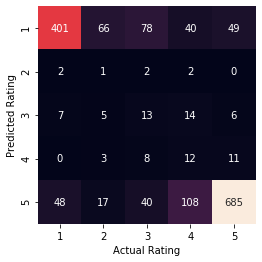

In [57]:
matrix = confusion_matrix(y_testglobal, y_pred_SVM_testglobal)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['1','2','3','4','5'], yticklabels=['1','2','3','4','5'])

plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

### SEA

In [58]:
starttime = datetime.now()

#######

#svm_gridsea = GridSearchCV(SVMsea, svm_param_grid, refit=True, verbose=3)

#svm_gridsea.fit(tfidf_X_trainsea, y_trainsea)

#######

print(datetime.now() - starttime)

# Takes too long to run.

0:00:00.000067


In [59]:
#print(svm_gridsea.best_params_)
#print(svm_gridsea.best_estimator_)

In [60]:
starttime = datetime.now()

#######

SVMsea = svm.SVC(C=1, gamma=1, kernel='linear')
SVMsea.fit(tfidf_X_trainsea, y_trainsea)

y_pred_SVM_testsea = SVMsea.predict(tfidf_X_testsea)

print("Test Accuracy Score:", metrics.accuracy_score(y_testsea, y_pred_SVM_testsea))
print("Test Precision Score:", metrics.precision_score(y_testsea, y_pred_SVM_testsea, average = "weighted"))
print("Test Recall Score:", metrics.recall_score(y_testsea, y_pred_SVM_testsea, average = "weighted"))
print("Test F1 Score:", metrics.f1_score(y_testsea, y_pred_SVM_testsea, average = "weighted"))

#######

print('---------------------')
print(datetime.now() - starttime)

Test Accuracy Score: 0.7683609556011307
Test Precision Score: 0.6819928440383624
Test Recall Score: 0.7683609556011307
Test F1 Score: 0.7082950567050916
---------------------
0:05:43.690476


Compared to:
- Test Accuracy Score: 0.7723518651959426 (DECREASE)
- Test Precision Score: 0.6895906690359215 (DECREASE)
- Test Recall Score: 0.7723518651959426 (DECREASE)
- Test F1 Score: 0.7100195104243602 (DECREASE)

Text(91.68, 0.5, 'Predicted Rating')

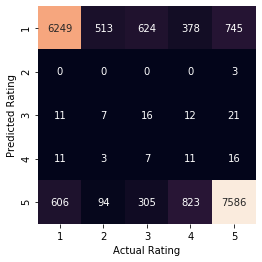

In [61]:
matrix = confusion_matrix(y_testsea, y_pred_SVM_testsea)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=['1','2','3','4','5'], yticklabels=['1','2','3','4','5'])

plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

==================================================================================================================

# Summary of Models

We will be using Accuracy and F1 score to indicate performance of the models

## Global Models:

- Dummy Classifier: 33.19% Accuracy, 32.79% F1 Score
- Naive Bayes: 66.87% Accuracy, 58.90% F1 Score
- Decision Tree: 58.28% Accuracy, 56.51% F1 Score
- Random Forest: 66.75% Accuracy, 58.00% F1 Score
- Support Vector Machine: 68.42% Accuracy, 59.50% F1 Score

#### GridSearch Global

- DT: 59.15% Accuracy, 52.87% F1 Score
- RF: 67.49% Accuracy, 58.38% F1 Score
- SVT: 68.72% Accuracy, 61.93% F1 Score

## SEA Models:

- Dummy Classifier: 36.67% Accuracy, 36.84% F1 Score
- Naive Bayes: 72.62% Accuracy, 69.06% F1 Score
- Decision Tree 69.87% Accuracy, 68.03% F1 Score
- Random Forest: 75.54% Accuracy, 69.82% F1 Score
- Support Vector Machine: 77.24% Accuracy, 71.00% F1 Score

#### GridSearch SEA

- DT: 72.09% Accuracy, 67.33% F1 Score
- RF: N/A (75.44% Accuracy, 70.05% F1 Score)
- SVT: N/A (76.84% Accuracy, 70.83% F1 Score)

# Best Models

Global:

- Support Vector Machine (gridsearch): 68.73% Accuracy, 61.93% F1 Score

SEA:

- Support Vector Machine (no gridsearch): 77.24% Accuracy, 71.00% F1 Score